#  TP1 - Análisis de Plataforma de Ventas Online

## Aprendizaje de máquina I

### Domenje, Carlos R.

Una plataforma de ventas online nos contrata para que realicemos un modelo que nos permita detectar un posible fraude dada cierta operación para ello contamos con un dataset

https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset

Utilizando los modelos de clasificación vistos hasta el momento generar un notebook que permita de ser posible resolver el problema que nos está planteando el cliente.

## Análisis de Datos

En primer lugar se importa el dataset, para luego, a través de las diferentes funciones vistas en la cátedra poder realizar un analisis preliminar de los datos.

In [1]:
# Librerias a utilizar
import pandas as pd
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import scipy.stats as stats
import sklearn
# Seteamos 3 decimales para la muestra de datos en el dataset.
pd.set_option('display.float_format', lambda x: '%.3f' % x)

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,plot_confusion_matrix,roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, auc

import warnings
warnings.filterwarnings("ignore")

# Versiones de librerías
print("".join(f"{x[0]}:{x[1]}\n" for x in [
    ("Pandas",pd.__version__),
    ("Numpy",np.__version__),
    ("Matplotlib",matplotlib.__version__),
    ("SKlearn",sklearn.__version__),
    ("Seaborn",sns.__version__)
]))

Pandas:1.4.3
Numpy:1.19.5
Matplotlib:3.5.2
SKlearn:1.1.1
Seaborn:0.11.2



In [2]:
# Path del dataset a utilizar.
DATASET_PATH = "./data"

In [3]:
# Listado de archivos que se encuentran en el path
!ls {DATASET_PATH}

sales.csv


### Carga del dataset

Se realiza la lectura del dataset, y ademas se utiliza la funcion **head()** para obtener una visualización primaria de los primeros valores de los datos. 

Luego para mas detalles, se utiliza la función **describe()** que nos da una idea desde el punto de vista estadístico de los datos de nuestro dataset. 

In [2]:
# Lectura del dataset
df = pd.read_csv("./data/sales.csv")

# Para obtener una primer aproximación de cada columna, 
# podemos utilizar la funcion head, que nos mostrará las 5 primeras filas con sus respectivas columnas del dataset
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.640,C1231006815,170136.000,160296.360,M1979787155,0.000,0.000,0,0
1,1,PAYMENT,1864.280,C1666544295,21249.000,19384.720,M2044282225,0.000,0.000,0,0
2,1,TRANSFER,181.000,C1305486145,181.000,0.000,C553264065,0.000,0.000,1,0
3,1,CASH_OUT,181.000,C840083671,181.000,0.000,C38997010,21182.000,0.000,1,0
4,1,PAYMENT,11668.140,C2048537720,41554.000,29885.860,M1230701703,0.000,0.000,0,0


In [5]:
# Realizamos una exploración de los datos con describe
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620.000,6362620.000,6362620.000,6362620.000,6362620.000,6362620.000,6362620.000,6362620.000
mean,243.397,179861.904,833883.104,855113.669,1100701.667,1224996.398,0.001,0.000
std,142.332,603858.231,2888242.673,2924048.503,3399180.113,3674128.942,0.036,0.002
min,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,156.000,13389.570,0.000,0.000,0.000,0.000,0.000,0.000
50%,239.000,74871.940,14208.000,0.000,132705.665,214661.440,0.000,0.000
75%,335.000,208721.478,107315.175,144258.410,943036.708,1111909.250,0.000,0.000
max,743.000,92445516.640,59585040.370,49585040.370,356015889.350,356179278.920,1.000,1.000


### Verificación de datos nulos

In [6]:
# Verifico por datos nulos en cada columna.
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [7]:
# Tipos de datos que tenemos en el dataset

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


### Distribución de las variables

Se utiliza una función para visualizar de forma gráfica las diferentes features del dataset. Con esta información podremos obtener conclusiones sobre la utilidad de cada una de las variables y su peso en el target.

In [8]:
# Funcion para mostrar las distribuciones de las variables.

def display_dataset_distributions(dataset):
    fig = dataset.hist(xlabelsize=12, ylabelsize=12,figsize=(22,10))
    [x.title.set_size(14) for x in fig.ravel()]
    plt.tight_layout()
    plt.show()

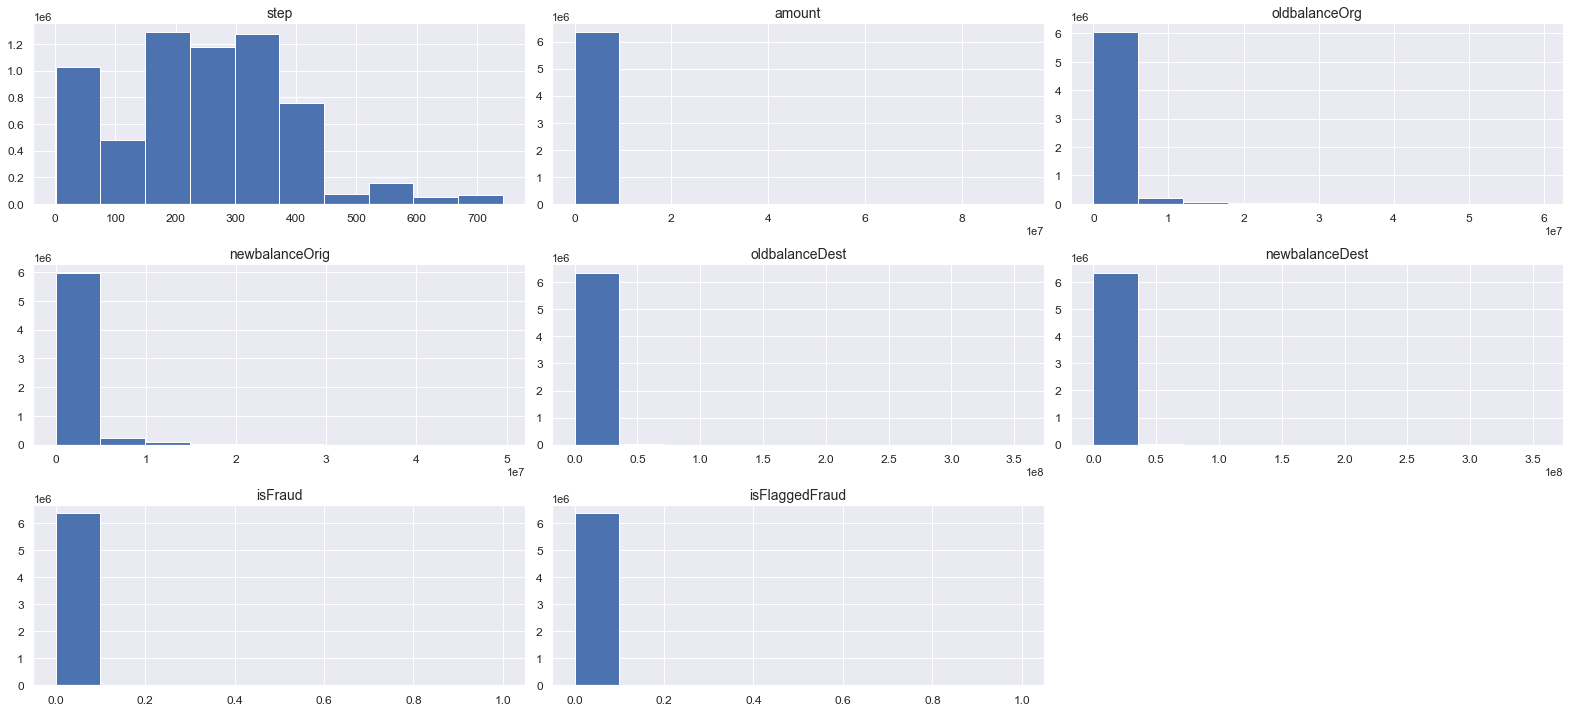

In [9]:
display_dataset_distributions(df)

### Detección de datos valores atípicos (Outliers)

Se implementa una función para visualizar si las variables contienen valores que puedan ser catalogados como atípicos y así poder tomar medidas sobre su utilización o no en el análisis.

Para ello, se realiza un histograma, un gráfico de distribución y un gráfico de cajas. 

In [10]:
def outlier_diagnostic_plots(df, variable):
    fig,axes = plt.subplots(1,3,figsize=(20,4))

    sns.histplot(df[variable], bins=30,ax=axes[0], kde=True)
    axes[0].set_title('Histograma')
    
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    axes[1].set_title('QQ')
    
    # boxplot    
    sns.boxplot(y=df[variable],ax=axes[2])
    axes[2].set_title('Box&Whiskers')

#### Variable STEP

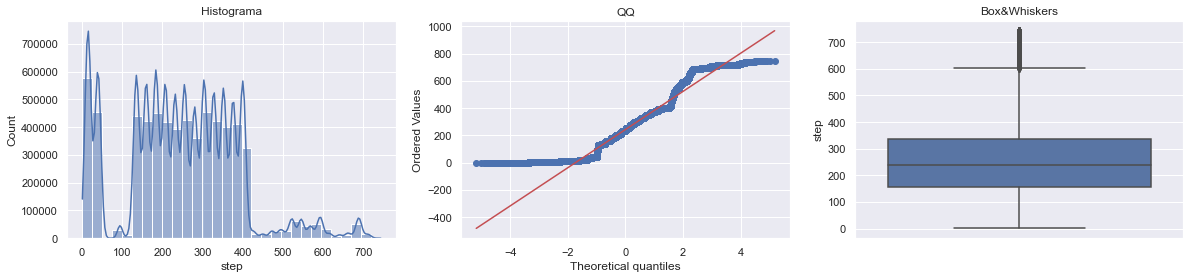

In [11]:
outlier_diagnostic_plots(df,'step')

#### Variable AMOUNT

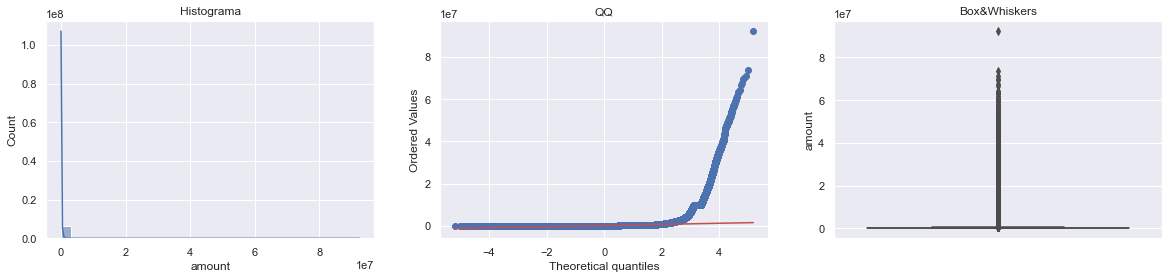

In [12]:
outlier_diagnostic_plots(df,'amount')

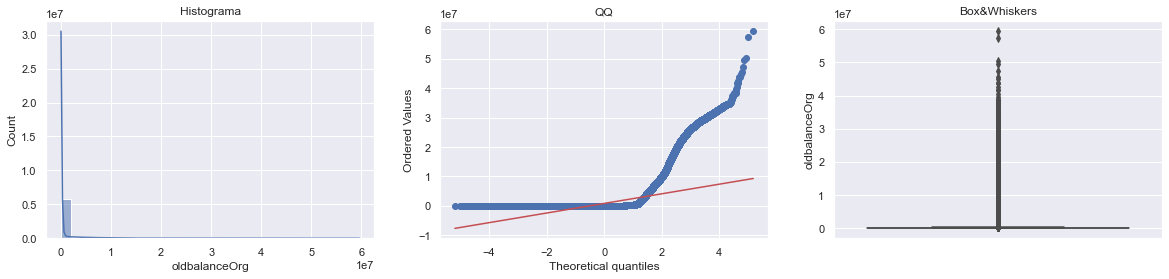

In [17]:
outlier_diagnostic_plots(df,'oldbalanceOrg')

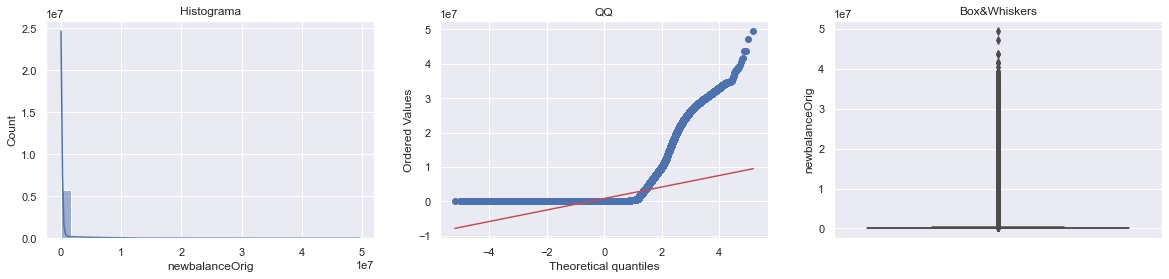

In [18]:
outlier_diagnostic_plots(df,'newbalanceOrig')

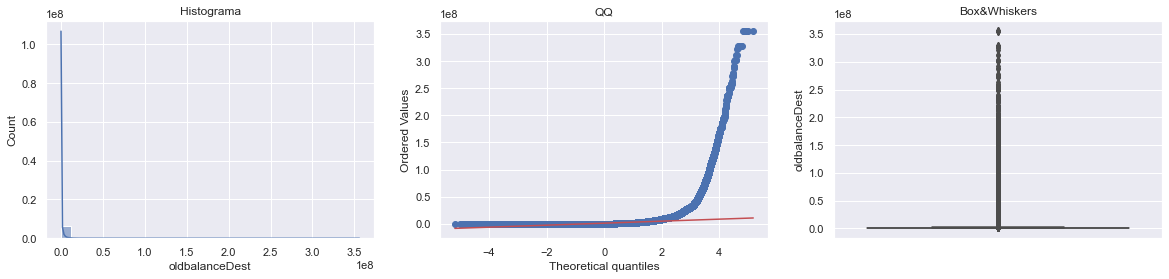

In [19]:
outlier_diagnostic_plots(df,'oldbalanceDest')

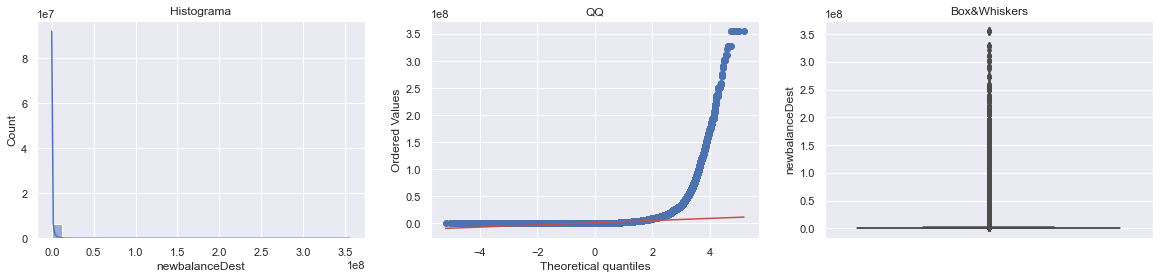

In [20]:
outlier_diagnostic_plots(df,'newbalanceDest')

### Transformación de variables

Se puede utilizar la transformación de algunas de las variables previamente analizadas para que cumplan con una distribución normal. Esto se realiza para que los algoritmos que vamos a utilizar posteriormente, puedan llegar a converger mas facilmente ya que muchos de ellos asumen que los datos tienen esta distribución.

In [13]:
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

def test_transformers(df_column):
    pt = PowerTransformer()
    qt = QuantileTransformer(n_quantiles=500, output_distribution='normal')
    fig = plt.figure(figsize=(20,30))
    j = 1
    array = np.array(df[{df_column}]).reshape(-1, 1)
    y = pt.fit_transform(df[{df_column}])
    x = qt.fit_transform(df[{df_column}])
    plt.subplot(3,3,j)
    sns.histplot(array, bins = 50, kde = True)
    plt.title(f"Distribución Original de {df_column}")
    plt.subplot(3,3,j+1)
    sns.histplot(x, bins = 50, kde = True)
    plt.title(f"Quantile Transform de {df_column}")
    plt.subplot(3,3,j+2)
    sns.histplot(y, bins = 50, kde = True)
    plt.title(f"Power Transform for {df_column}")
    
        

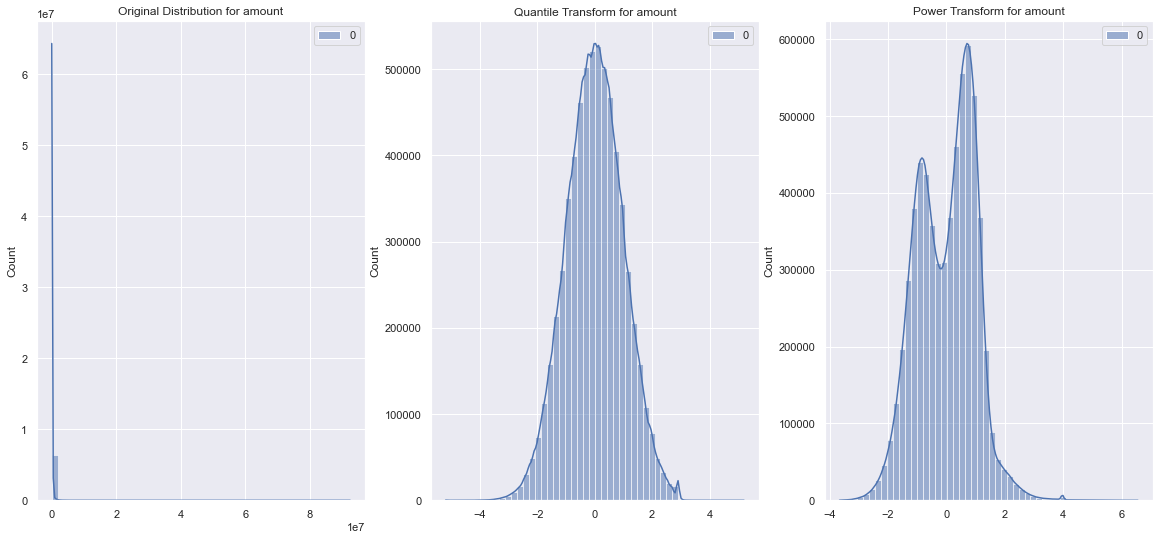

In [14]:

test_transformers('amount')

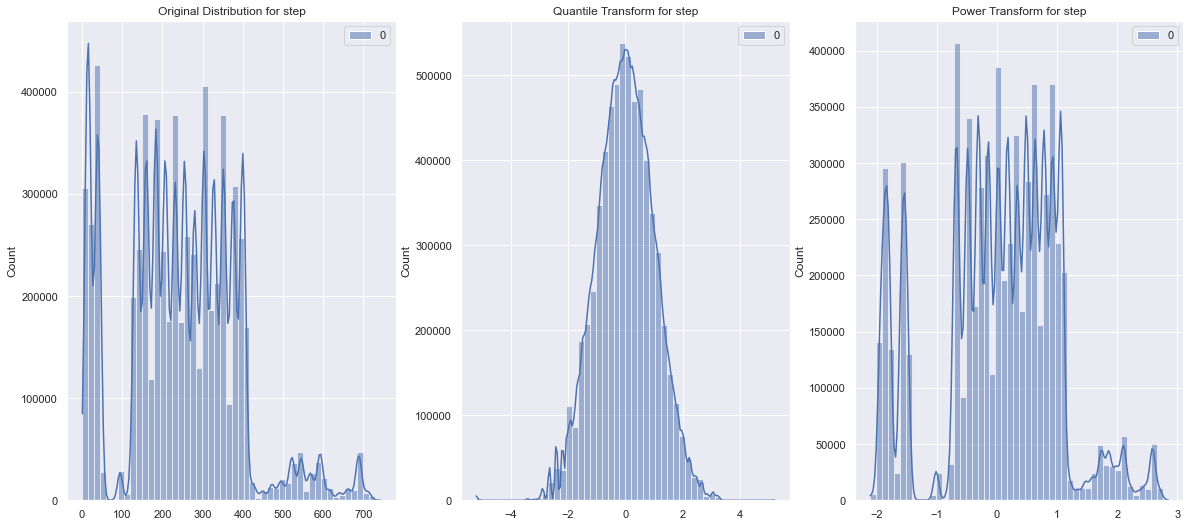

In [15]:
test_transformers('step')

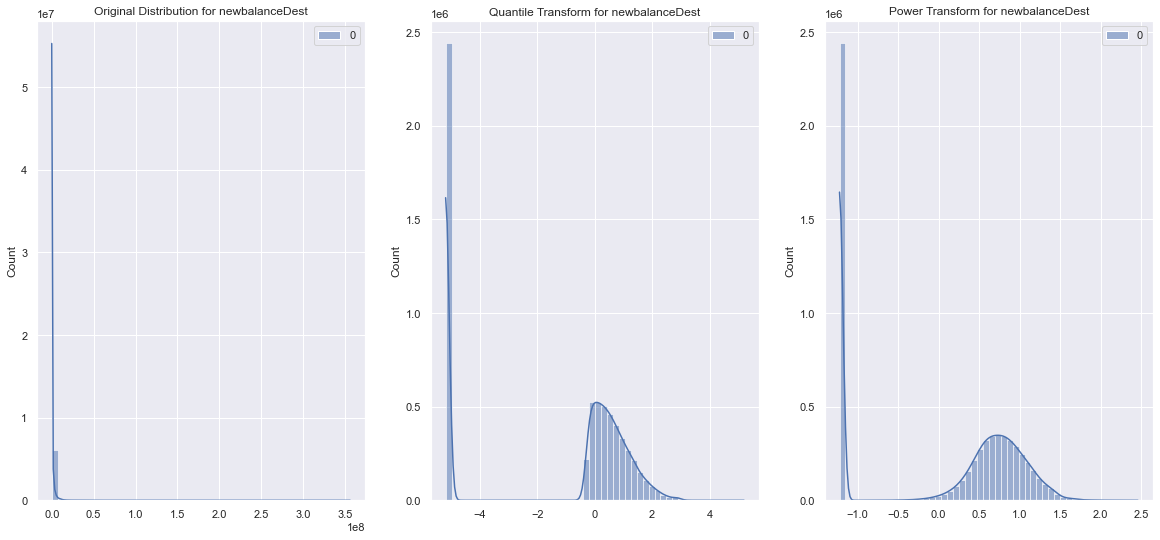

In [16]:
test_transformers('newbalanceDest')

### Análisis Gráfico de las variables.

Se realiza una impresión gráfica de las variables, teniendo en cuenta la variable categórica TYPE como una cuenta de cada tipo de pago. 

<AxesSubplot:xlabel='type', ylabel='isFraud'>

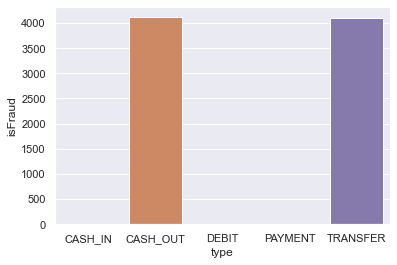

In [21]:
t=pd.DataFrame(df.groupby(by=df['type'])['isFraud'].sum())
sns.barplot(data=t,x=t.index, y='isFraud')

<AxesSubplot:>

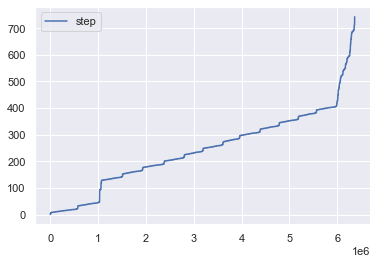

In [22]:
df.plot(kind='line', y='step')

<AxesSubplot:>

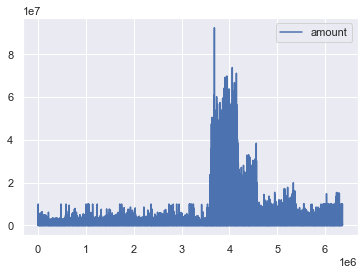

In [23]:
df.plot(kind='line', y='amount')

<AxesSubplot:>

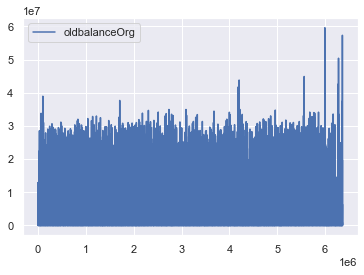

In [24]:
df.plot(kind='line',y='oldbalanceOrg')

<AxesSubplot:>

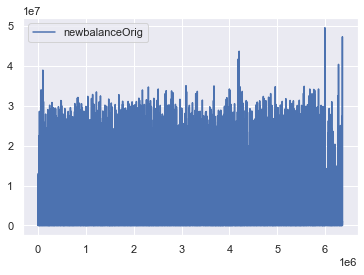

In [25]:
df.plot(kind='line', y='newbalanceOrig')

<AxesSubplot:>

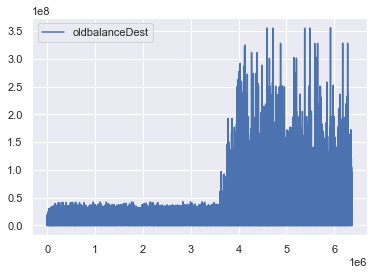

In [26]:
df.plot(kind='line', y='oldbalanceDest')

<AxesSubplot:>

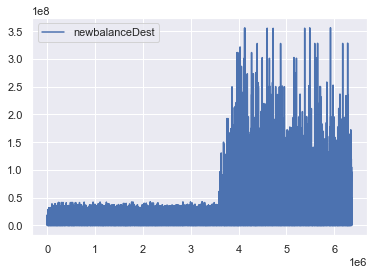

In [27]:
df.plot(kind='line', y='newbalanceDest')

### Análisis de la variable de salida

Se realiza un análisis de la variable de salida **isFraud**, en la cuál podremos ver si está balanceada o nó.

In [28]:
# Observamos el balance entre la salida con fraude detectado. 
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

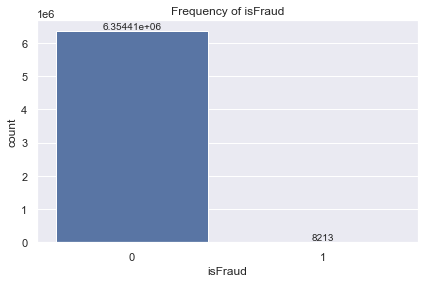

In [29]:
fig = plt.figure()
ax = sns.countplot(x='isFraud', data=df)
for container in ax.containers:
    ax.bar_label(container)
plt.tight_layout()
plt.title('Frequency of isFraud')
plt.show(fig)

#### Variable isFlaggedFraud

Vemos que la variable isFlaggedFraud contiene solamente un valor, lo cual no nos aporta información para nuestro análisis. 

In [30]:
# Observamos que la columna de fraude marcado solo tiene valores unicos iguales a cero. 
print(df['isFlaggedFraud'].value_counts(normalize=True))

0   1.000
1   0.000
Name: isFlaggedFraud, dtype: float64


### Gráfico de Correlación de las variables.

Se realiza un gráfico de como las variables se relacionan entre sí y como es la dependencia o independencia de cada una de ellas con las demás.

<AxesSubplot:>

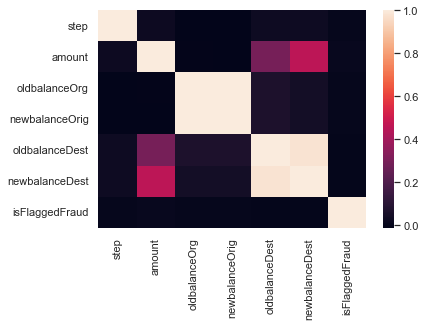

In [31]:
sns.heatmap(df.loc[:, df.columns != 'isFraud'].corr())

### Transformación de la variable categórica TYPE

Se realiza un análisis mas profundo de la variable categórica TYPE y se realiza una transformación a variable numérica, tomando cada categoria como columna.

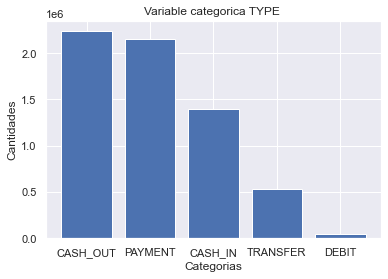

In [32]:
# La variable type, es de tipo categorica, y tiene las siguientes cantidades de datos por cada categoria.

type_feature = df['type'].value_counts()

plt.title('Variable categorica TYPE ')
plt.xlabel('Categorias')
plt.ylabel('Cantidades')
plt.bar(type_feature.index, type_feature.values)

plt.show()

In [3]:
# Creamos 4 columnas con la funcion get_dummies para reemplazar a la variable categorica.

dummyType = pd.get_dummies(df.type)

dummyType.head()

,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,0,1
3,0,1,0,0,0
4,0,0,0,1,0


In [4]:
# Concatenamos las nuevas columnas al dataframe y tiramos la variable type y isFlaggedFraud (contiene solo ceros)

df = pd.concat([df,dummyType], axis='columns')
newDF = df.drop(['type', 'isFlaggedFraud', 'nameOrig', 'nameDest'], axis='columns')
newDF.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,9839.640,170136.000,160296.360,0.000,0.000,0,0,0,0,1,0
1,1,1864.280,21249.000,19384.720,0.000,0.000,0,0,0,0,1,0
2,1,181.000,181.000,0.000,0.000,0.000,1,0,0,0,0,1
3,1,181.000,181.000,0.000,21182.000,0.000,1,0,1,0,0,0
4,1,11668.140,41554.000,29885.860,0.000,0.000,0,0,0,0,1,0


## Predicción utilizando Regresión Lineal

In [35]:
#Importamos las bibliotecas que usaremos para hacer las prediciones.

from sklearn.linear_model import LinearRegression

### Separación de variables en Train y Test

In [5]:
# Separamos el dataset en train y test
# Tomamos el dataset sin la columna que vamos a predecir.

X_train, X_test, y_train, y_test = train_test_split(\
    newDF.drop(['isFraud'], axis=1),\
    newDF['isFraud'],\
    stratify = newDF['isFraud'],\
    random_state=0)

# chequeamos la presencia relativa de cada clase y el tamaño de los datasets
print('Entrenamiento:',X_train.shape)
print('Testeo:',X_test.shape)
print('\nClases train:')
print(y_train.value_counts(normalize=True))
print('\nClases test:')
print(y_test.value_counts(normalize=True))


Entrenamiento: (4771965, 11)
Testeo: (1590655, 11)

Clases train:
0   0.999
1   0.001
Name: isFraud, dtype: float64

Clases test:
0   0.999
1   0.001
Name: isFraud, dtype: float64


### Regresión logística

Realizamos la predicción utilizando Regresión Logística.

In [85]:


def logistic_regression_report(X_train,X_test,y_train,y_test):
    
    scaler=StandardScaler()  
    
    X_train_sc=scaler.fit_transform(X_train) # Estandarizamos los datos     
    X_test_sc=scaler.transform(X_test)
        
    model=LogisticRegression(max_iter=1000, n_jobs=-1)
    
    model.fit(X_train_sc,y_train)
    y_pred=model.predict(X_test_sc)
    y_proba=model.predict_proba(X_test_sc)
    
    print(classification_report(y_test,y_pred))
    
    print('Area bajo la curva ROC:',np.round(roc_auc_score(y_test,y_proba[:,1]),4))
    
    precision, recall,threshold=precision_recall_curve(y_test,y_proba[:,1]);

    print('Area bajo la curva Precision-Recall:',np.round(auc(recall,precision),4))

    plot_confusion_matrix(model,X_test_sc,y_test,cmap='Blues');

    print("Accuracy : {:0.4f}".format(accuracy_score(y_test,y_pred)))
    return

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588602
           1       0.92      0.44      0.59      2053

    accuracy                           1.00   1590655
   macro avg       0.96      0.72      0.80   1590655
weighted avg       1.00      1.00      1.00   1590655

Area bajo la curva ROC: 0.9823
Area bajo la curva Precision-Recall: 0.6243
Accuracy : 0.9992


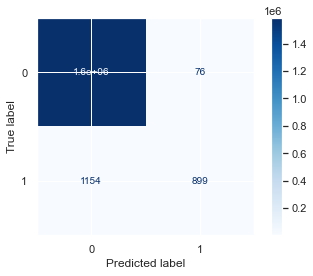

In [86]:
logistic_regression_report(X_train,X_test,y_train,y_test)

### Utilización de Under Sampling

Se realiza un under sampleo de los datos para poder balancear hacia el resultado que menos aparece en la salida. Luego se vuelve a realizar la predicción utilizando regresion lineal.


In [87]:
from imblearn.under_sampling import RandomUnderSampler
undersampler=RandomUnderSampler(sampling_strategy='majority')

X_train_us,y_train_us=undersampler.fit_resample(X_train,y_train);

print('Composición del training set:')
print(y_train_us.value_counts())

print('\nComposición del test set:')
print(y_test.value_counts())

Composición del training set:
0    6160
1    6160
Name: isFraud, dtype: int64

Composición del test set:
0    1588602
1       2053
Name: isFraud, dtype: int64


              precision    recall  f1-score   support

           0       1.00      0.93      0.96   1588602
           1       0.02      0.91      0.03      2053

    accuracy                           0.93   1590655
   macro avg       0.51      0.92      0.50   1590655
weighted avg       1.00      0.93      0.96   1590655

Area bajo la curva ROC: 0.9793
Area bajo la curva Precision-Recall: 0.5547
Accuracy : 0.9301


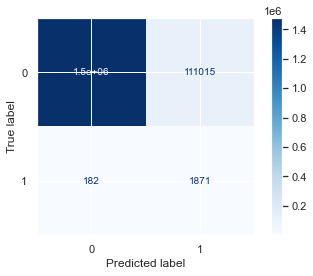

In [88]:
logistic_regression_report(X_train_us, X_test, y_train_us, y_test)

### Utilización de Over Sampling

Se utiliza un over sampling para llevar a los resultados que menos aparación tienen hacia los que mas aparecen y luego se utiliza regresión lineal.

In [89]:
from imblearn.over_sampling import RandomOverSampler
oversampler=RandomOverSampler(sampling_strategy='minority');

X_train_os,y_train_os=oversampler.fit_resample(X_train,y_train);

print('Composición del training set:')
print(y_train_os.value_counts())

print('\nComposición del test set:')
print(y_test.value_counts())


Composición del training set:
0    4765805
1    4765805
Name: isFraud, dtype: int64

Composición del test set:
0    1588602
1       2053
Name: isFraud, dtype: int64


              precision    recall  f1-score   support

           0       1.00      0.95      0.97   1588602
           1       0.02      0.94      0.05      2053

    accuracy                           0.95   1590655
   macro avg       0.51      0.95      0.51   1590655
weighted avg       1.00      0.95      0.97   1590655

Area bajo la curva ROC: 0.9893
Area bajo la curva Precision-Recall: 0.5811
Accuracy : 0.9508


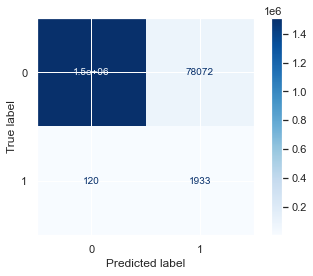

In [90]:
logistic_regression_report(X_train_os,X_test,y_train_os,y_test)

### Utilización de Class Weighting

Se realiza una regresión logística utilizando el parametro class_weight como balanceada y se evalua su resultado.

              precision    recall  f1-score   support

           0       1.00      0.95      0.97   1588602
           1       0.02      0.94      0.05      2053

    accuracy                           0.95   1590655
   macro avg       0.51      0.95      0.51   1590655
weighted avg       1.00      0.95      0.97   1590655

Area bajo la curva ROC: 0.9892228533718491
Area bajo la curva Precision-Recall: 0.5812333536583696


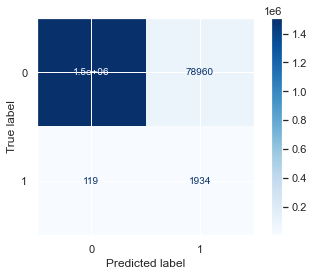

In [91]:
# Class weighting

model = LogisticRegression(class_weight = 'balanced')

scaler=StandardScaler()

X_train_sc=scaler.fit_transform(X_train);
X_test_sc=scaler.transform(X_test);

model.fit(X_train_sc,y_train)
y_pred = model.predict(X_test_sc)
pred_probas = model.predict_proba(X_test_sc);

print(classification_report(y_test,y_pred))
plot_confusion_matrix(model,X_test_sc,y_test,cmap='Blues');

print('Area bajo la curva ROC:',roc_auc_score(y_test,pred_probas[:,1]))

precision, recall,threshold=precision_recall_curve(y_test,pred_probas[:,1]);

print('Area bajo la curva Precision-Recall:',auc(recall,precision))


### Regresión Logística utilizando QuantileTransformer

Se utiliza class_weight y además se transforman las variables utilizando QuantileTransformer ya que previamente en el análisis gráfico vimos que para algunas columnas resultaba ser positivo.

              precision    recall  f1-score   support

           0       1.00      0.93      0.96   1588602
           1       0.02      0.98      0.04      2053

    accuracy                           0.93   1590655
   macro avg       0.51      0.95      0.50   1590655
weighted avg       1.00      0.93      0.96   1590655

Area bajo la curva ROC: 0.9924612872666221
Area bajo la curva Precision-Recall: 0.5143847467024449


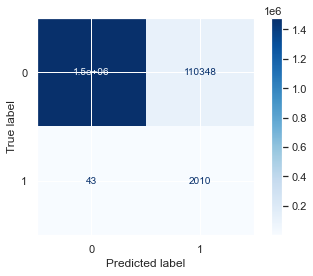

In [93]:
# Aplicación de QuantileTransformer al modelo para el calculo de regresion.

model = LogisticRegression(class_weight = 'balanced', n_jobs=-1)

qt = QuantileTransformer(n_quantiles=500, output_distribution='normal')
X_train_qt = qt.fit_transform(X_train)
X_test_qt = qt.fit_transform(X_test)
model.fit(X_train_qt,y_train)
y_pred = model.predict(X_test_qt)
pred_probas = model.predict_proba(X_test_qt);

print(classification_report(y_test,y_pred))
plot_confusion_matrix(model,X_test_qt,y_test,cmap='Blues');

print('Area bajo la curva ROC:',roc_auc_score(y_test,pred_probas[:,1]))

precision, recall,threshold=precision_recall_curve(y_test,pred_probas[:,1]);

print('Area bajo la curva Precision-Recall:',auc(recall,precision))


## Conclusión

Los valores de la diagonal principal a=1.5e6 y d=2010 se corresponden con los valores estimados de forma correcta por el modelo, tanto los verdaderos positivos_ TP(d), como los verdaderos negativos_TN (a).

La otra diagonal, por tanto, representa los casos en los que el modelo se ha equivocado (c=43 falsos negativos_FN, b=110348 falsos positivos_FP).

La exactitud (o accuracy) representa el porcentaje de predicciones correctas frente al total. Por tanto, es el cociente entre los casos bien clasificados por el modelo (verdaderos positivos y verdaderos negativos, es decir, los valores en la diagonal de la matriz de confusión), y la suma de todos los casos.

Sin embargo, cuando un conjunto de datos es poco equilibrado, no es una métrica útil.

La precisión, (o“precision”) se refiere a lo cerca que está el resultado de una predicción del valor verdadero. Por tanto, es el cociente entre los casos positivos bien clasificados por el modelo y el total de predicciones positivas. 

La sensibilidad (o recall) representa la tasa de verdaderos positivos (True Positive Rate) ó TP. Es la proporción entre los casos positivos bien clasificados por el modelo, respecto al total de positivos. 

Como podemos ver en los diferentes resultados utilizando regresión logistica, tenemos mejoras circustanciales utilizando la normalizacion de los datos y ademas el class weighting aunque tenemos una baja significativa en la presicion. En este caso mejora la detección de los casos positivos pero disminuye la deteccion de los negativos por lo que se deberá evaluar según los requerimientos del problema.

## Decision Tree

Se realiza el análisis utilizando Decision Tree

In [95]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

treeModel = DecisionTreeClassifier(max_depth=5, criterion='entropy')
# Entrenamos el modelo con los datos desbalanceados.
treeModel.fit(X_train,y_train)

y_pred = treeModel.predict(X_test)


### Score del Arbol de Decision.

In [96]:
print(treeModel.score(X_test,y_test))

0.9995316394818486


### Plot del Arbol con 5 capas.

[Text(0.4864864864864865, 0.9166666666666666, 'X[1] <= 590228.719\nentropy = 0.014\nsamples = 4771965\nvalue = [4765805, 6160]'),
 Text(0.22297297297297297, 0.75, 'X[10] <= 0.5\nentropy = 0.009\nsamples = 4579433\nvalue = [4575962, 3471]'),
 Text(0.08108108108108109, 0.5833333333333334, 'X[7] <= 0.5\nentropy = 0.005\nsamples = 4351074\nvalue = [4349345, 1729]'),
 Text(0.05405405405405406, 0.4166666666666667, 'entropy = 0.0\nsamples = 2687789\nvalue = [2687789, 0]'),
 Text(0.10810810810810811, 0.4166666666666667, 'X[2] <= 54235.35\nentropy = 0.012\nsamples = 1663285\nvalue = [1661556, 1729]'),
 Text(0.05405405405405406, 0.25, 'X[1] <= 53340.469\nentropy = 0.004\nsamples = 1368574\nvalue = [1368158, 416]'),
 Text(0.02702702702702703, 0.08333333333333333, 'entropy = 0.017\nsamples = 253547\nvalue = [253148, 399]'),
 Text(0.08108108108108109, 0.08333333333333333, 'entropy = 0.0\nsamples = 1115027\nvalue = [1115010, 17]'),
 Text(0.16216216216216217, 0.25, 'X[3] <= 0.435\nentropy = 0.041\nsa

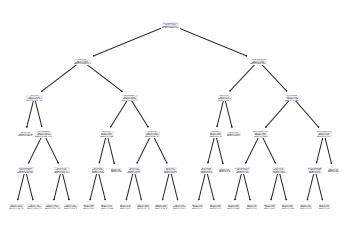

In [97]:
tree.plot_tree(treeModel)

### Reporte de la clasificación

In [98]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588602
           1       0.91      0.70      0.80      2053

    accuracy                           1.00   1590655
   macro avg       0.96      0.85      0.90   1590655
weighted avg       1.00      1.00      1.00   1590655



### Matriz de Confusión

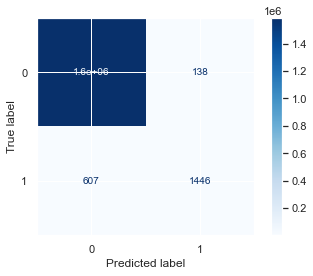

In [101]:
plot_confusion_matrix(treeModel,X_test,y_test,cmap='Blues')

## Random Forest

Utilización de Random Forest para la detección de fraude.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588602
           1       0.97      0.78      0.87      2053

    accuracy                           1.00   1590655
   macro avg       0.99      0.89      0.93   1590655
weighted avg       1.00      1.00      1.00   1590655



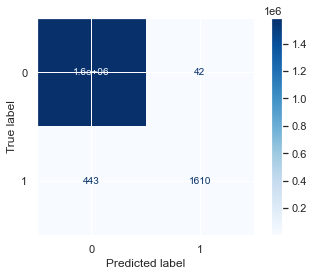

In [103]:
from sklearn.ensemble import RandomForestClassifier
# Instanciamos el modelo con 10 árboles de decisión
rf = RandomForestClassifier(n_estimators=20, criterion='entropy', n_jobs=-1)
# Entrenamos el modelo con los datos de entrenamiento
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))
plot_confusion_matrix(rf,X_test,y_test,cmap='Blues')

## Conclusión

Como podemos ver en las métricas, la mejor decision es utilizar RandomForest para el análisis de fraude.